In [ ]:
import bt

In [ ]:
%matplotlib inline

In [ ]:
# fetch some data
data = bt.get('BTC-USD,ETH-USD', start='2010-01-01')
print(data.head())

In [ ]:
data

In [ ]:
# create the strategy
s = bt.Strategy('s1', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

In [ ]:
# create a backtest and run it
test = bt.Backtest(s, data)
res = bt.run(test)

In [ ]:
# first let's see an equity curve
res.plot();

In [ ]:
# ok and what about some stats?
res.display()

In [ ]:
# ok and how does the return distribution look like?
res.plot_histogram()

In [ ]:
# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()

In [ ]:
# create our new strategy
s2 = bt.Strategy('s2', [bt.algos.RunWeekly(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])

# now let's test it with the same data set. We will also compare it with our first backtest.
test2 = bt.Backtest(s2, data)
# we include test here to see the results side-by-side
res2 = bt.run(test, test2)

res2.plot();

In [ ]:
res2.display()

In [ ]:
import bt
import pandas as pd
import yfinance as yf

# Función para obtener datos históricos
def obtener_datos(tickers, inicio='2020-01-01', fin=None):
    # Si fin no se especifica, usamos la fecha actual
    if fin is None:
        fin = pd.to_datetime('today').strftime('%Y-%m-%d')
    datos = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=inicio, end=fin)['Adj Close']
        datos[ticker] = stock
    return datos

# Definimos una estrategia simple de cruce de medias móviles
class EstrategiaCruceMedMovil(bt.Strategy):
    def __init__(self, corto=50, largo=200):
        super().__init__()
        self.corto = corto
        self.largo = largo
        
    def init(self):
        # Calculamos las medias móviles
        self.sma_corta = self.data.rolling(self.corto).mean()
        self.sma_larga = self.data.rolling(self.largo).mean()
        
    def __call__(self, target):
        # Compramos cuando la media corta cruza por encima de la larga
        señal = self.sma_corta > self.sma_larga
        
        # Asignamos pesos: 1 cuando hay señal de compra, 0 cuando no
        target.weights = señal.astype(float)
        
        # Rebalanceamos la cartera
        target.rebalance()

def ejecutar_backtest(tickers):
    # Obtenemos los datos
    datos = obtener_datos(tickers)
    
    # Creamos la estrategia
    estrategia = bt.Strategy('CruceMedMovil', 
                           [bt.algos.RunOnce(),
                            bt.algos.SelectAll(),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])
    
    # Configuramos y ejecutamos el backtest
    test = bt.Backtest(estrategia, datos)
    resultado = bt.run(test)
    
    return resultado

# Ejemplo de uso
if __name__ == "__main__":
    tickers = ['0P0001CLDK.F']
    resultado = ejecutar_backtest(tickers)
    
    # Mostrar resultados
    print("\nResumen del Backtest:")
    print(resultado.display())
    
    # Métricas clave
    print("\nMétricas de Rendimiento:")
    print(resultado.stats)
    
    # Graficar resultados
    resultado.plot()

INFO:__main__:Descargando datos para 0P0001CLDK.F
[*********************100%***********************]  1 of 1 completed
INFO:__main__:Ejecutando backtest para estrategia: Smart Trend
INFO:__main__:Ejecutando backtest para estrategia: Adaptive Volatility
INFO:__main__:Ejecutando backtest para estrategia: Smart Momentum
100%|██████████| 3/3 [00:00<00:00, 34.88it/s]



Resumen de Resultados:
Stat                 Smart Trend    Adaptive Volatility    Smart Momentum
-------------------  -------------  ---------------------  ----------------
Start                2020-01-01     2020-01-01             2020-01-01
End                  2023-12-29     2023-12-29             2023-12-29
Risk-free rate       0.00%          0.00%                  0.00%

Total Return         0.00%          0.00%                  0.00%
Daily Sharpe         -              -                      -
Daily Sortino        -              -                      -
CAGR                 0.00%          0.00%                  0.00%
Max Drawdown         0.00%          0.00%                  0.00%
Calmar Ratio         -              -                      -

MTD                  0.00%          0.00%                  0.00%
3m                   0.00%          0.00%                  0.00%
6m                   0.00%          0.00%                  0.00%
YTD                  0.00%          0.00%     

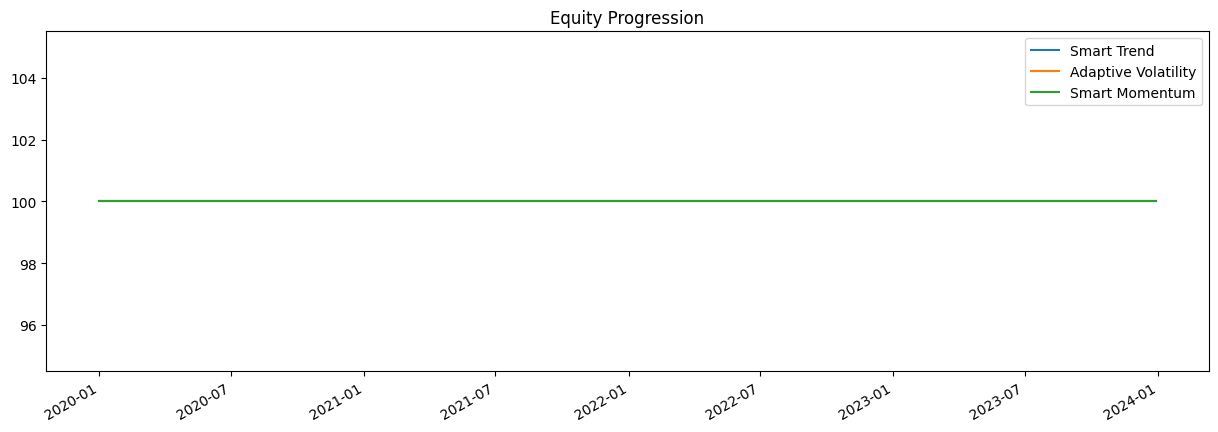

In [9]:
import bt
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from typing import Dict, List, Union, Optional
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class BaseStrategy(bt.Strategy):
    """Clase base para todas las estrategias."""
    
    def __init__(self, nombre: str, data):
        super().__init__(data)  # Pasamos data al constructor de bt.Strategy
        self.nombre = nombre
        self.data = data
        
    def init(self):
        """Método para inicializar indicadores."""
        self._configure_indicators()
    
    @abstractmethod
    def _configure_indicators(self) -> None:
        """Configurar los indicadores específicos de la estrategia."""
        pass
    
    @abstractmethod
    def generate_signals(self) -> pd.Series:
        """Generar señales de trading."""
        pass
    
    def __call__(self, target) -> None:
        """Implementación de la lógica de trading."""
        señales = self.generate_signals()
        target.weights = señales.astype(float)
        target.rebalance()

class SmartTrendStrategy(BaseStrategy):
    def __init__(self, data, lookback: int = 20, volatility_window: int = 20):
        super().__init__(nombre="Smart Trend", data=data)
        self.lookback = lookback
        self.volatility_window = volatility_window
    
    def _configure_indicators(self) -> None:
        # Creamos un DataFrame con OHLCV para usar pandas_ta
        self.df = pd.DataFrame({
            'close': self.data,
            'open': self.data,
            'high': self.data,
            'low': self.data,
            'volume': self.data * 0
        })
        
        # Indicadores de tendencia
        self.df['ema_short'] = self.df.ta.ema(length=self.lookback)
        self.df['ema_long'] = self.df.ta.ema(length=self.lookback * 2)
        self.df['psar'] = self.df.ta.psar()['PSARl_0.02_0.2']
        
        # Osciladores
        self.df['rsi'] = self.df.ta.rsi()
        self.df['stoch'] = self.df.ta.stoch()['STOCHk_14_3_3']
        
        # Volatilidad
        self.df['volatility'] = self.df['close'].pct_change().rolling(
            self.volatility_window).std()
    
    def generate_signals(self) -> pd.Series:
        señales = pd.Series(0, index=self.data.index)
        
        trend_condition = (
            (self.df['ema_short'] > self.df['ema_long']) &
            (self.df['close'] > self.df['psar'])
        )
        
        momentum_condition = (
            (self.df['rsi'] > 40) &
            (self.df['rsi'] < 70) &
            (self.df['stoch'] > 20)
        )
        
        volatility_condition = (
            self.df['volatility'] < self.df['volatility'].rolling(252).mean()
        )
        
        señales[trend_condition & momentum_condition & volatility_condition] = 1
        return señales

class AdaptiveVolatilityStrategy(BaseStrategy):
    def __init__(self, data, ventana_volatilidad: int = 21):
        super().__init__("Adaptive Volatility", data=data)
        self.ventana_volatilidad = ventana_volatilidad
    
    def _configure_indicators(self) -> None:
        self.df = pd.DataFrame({'close': self.data})
        
        # Indicadores de volatilidad
        self.df['atr'] = self.df.ta.atr(length=self.ventana_volatilidad)
        self.df['bbands'] = self.df.ta.bbands()['BBM_5_2.0']
        self.df['keltner'] = self.df.ta.kc()['KCM_20_2.0']
        
        # Momentum y tendencia
        self.df['adx'] = self.df.ta.adx()['ADX_14']
        self.df['mom'] = self.df.ta.mom()
        
        # Volatilidad normalizada
        self.df['vol_norm'] = (
            self.df['atr'] / self.df['atr'].rolling(252).mean()
        )
    
    def generate_signals(self) -> pd.Series:
        señales = pd.Series(0, index=self.data.index)
        
        squeeze_condition = (
            (self.df['bbands'] > self.df['keltner']) &
            (self.df['vol_norm'] < 1.5)
        )
        
        trend_strength = (
            (self.df['adx'] > 25) &
            (self.df['mom'] > 0)
        )
        
        exposicion = 1 / self.df['vol_norm']
        exposicion = exposicion.clip(upper=2)
        
        señales[squeeze_condition & trend_strength] = exposicion
        return señales

class SmartMomentumStrategy(BaseStrategy):
    def __init__(self, data, momentum_window: int = 90, vol_window: int = 21):
        super().__init__("Smart Momentum", data=data)
        self.momentum_window = momentum_window
        self.vol_window = vol_window
    
    def _configure_indicators(self) -> None:
        self.df = pd.DataFrame({'close': self.data})
        
        # Momentum indicators
        self.df['ppo'] = self.df.ta.ppo()['PPO_12_26_9']
        self.df['roc'] = self.df.ta.roc()
        self.df['tsi'] = self.df.ta.tsi()['TSI_13_25']
        
        # Trend indicators
        self.df['vwma'] = self.df.ta.vwma()
        self.df['tema'] = self.df.ta.tema()
        
        # Volatility indicators
        self.df['natr'] = self.df.ta.natr()
        
        # Momentum Score
        self.df['mom_score'] = (
            (self.df['ppo'] > 0).astype(int) +
            (self.df['roc'] > 0).astype(int) +
            (self.df['tsi'] > 0).astype(int)
        )
    
    def generate_signals(self) -> pd.Series:
        señales = pd.Series(0, index=self.data.index)
        
        strong_momentum = self.df['mom_score'] >= 2
        
        trend_confirmation = (
            (self.df['close'] > self.df['vwma']) &
            (self.df['close'] > self.df['tema'])
        )
        
        acceptable_volatility = (
            self.df['natr'] < self.df['natr'].rolling(252).mean()
        )
        
        position_size = self.df['mom_score'] / 3.0
        
        señales[strong_momentum & trend_confirmation & acceptable_volatility] = position_size
        return señales

class BacktestEngine:
    """Motor de backtesting para ejecutar y comparar estrategias."""
    
    def __init__(self, ticker: str, inicio: str, fin: str):
        self.ticker = ticker
        self.inicio = inicio
        self.fin = fin
        self.datos = self._obtener_datos()
        self.estrategias: List[BaseStrategy] = []
    
    def _obtener_datos(self) -> pd.DataFrame:
        logger.info(f"Descargando datos para {self.ticker}")
        try:
            datos = yf.download(self.ticker, start=self.inicio, end=self.fin)['Adj Close']
            return pd.DataFrame(datos)
        except Exception as e:
            logger.error(f"Error al obtener datos: {e}")
            raise
    
    def agregar_estrategia(self, estrategia: BaseStrategy) -> None:
        self.estrategias.append(estrategia)
    
    def ejecutar_backtest(self) -> bt.backtest.Result:
        tests = []
        
        for estrategia in self.estrategias:
            logger.info(f"Ejecutando backtest para estrategia: {estrategia.nombre}")
            
            test = bt.Backtest(
                estrategia,
                self.datos,
                name=estrategia.nombre,
                initial_capital=100000,
                commissions=lambda q, p: abs(q) * p * 0.001
            )
            tests.append(test)
        
        return bt.run(*tests)

def main():
    # Configuración
    ticker = '0P0001CLDK.F'
    inicio = '2020-01-01'
    fin = '2023-12-31'
    
    # Inicializar motor de backtest
    engine = BacktestEngine(ticker, inicio, fin)
    
    # Crear estrategias pasando los datos
    estrategias = [
        SmartTrendStrategy(engine.datos, lookback=20, volatility_window=20),
        AdaptiveVolatilityStrategy(engine.datos, ventana_volatilidad=21),
        SmartMomentumStrategy(engine.datos, momentum_window=90, vol_window=21)
    ]
    
    # Agregar estrategias
    for estrategia in estrategias:
        engine.agregar_estrategia(estrategia)
    
    # Ejecutar backtest
    resultados = engine.ejecutar_backtest()
    
    # Mostrar resultados
    print("\nResumen de Resultados:")
    print(resultados.display())
    
    print("\nMétricas por Estrategia:")
    print(resultados.stats)
    
    # Visualización
    resultados.plot()
    
    return resultados

if __name__ == "__main__":
    resultados = main()

INFO:__main__:Descargando datos para 0P0001CLDK.F
[*********************100%***********************]  1 of 1 completed
100%|██████████| 1/1 [00:00<00:00, 37.04it/s]



Resumen de la estrategia DCA:
Stat                 DCA_0P0001CLDK.F
-------------------  ------------------
Start                2020-01-01
End                  2023-12-29
Risk-free rate       0.00%

Total Return         0.00%
Daily Sharpe         -
Daily Sortino        -
CAGR                 0.00%
Max Drawdown         0.00%
Calmar Ratio         -

MTD                  0.00%
3m                   0.00%
6m                   0.00%
YTD                  0.00%
1Y                   0.00%
3Y (ann.)            0.00%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  0.00%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    0.00%
Daily Vol (ann.)     0.00%
Daily Skew           0.00
Daily Kurt           -
Best Day             0.00%
Worst Day            0.00%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  0.00%
Monthly Vol (ann.)   0.00%
Monthly Skew         0.00
Monthly Kurt         -
Best Month           0.00%
Worst Month          0.00%

Year

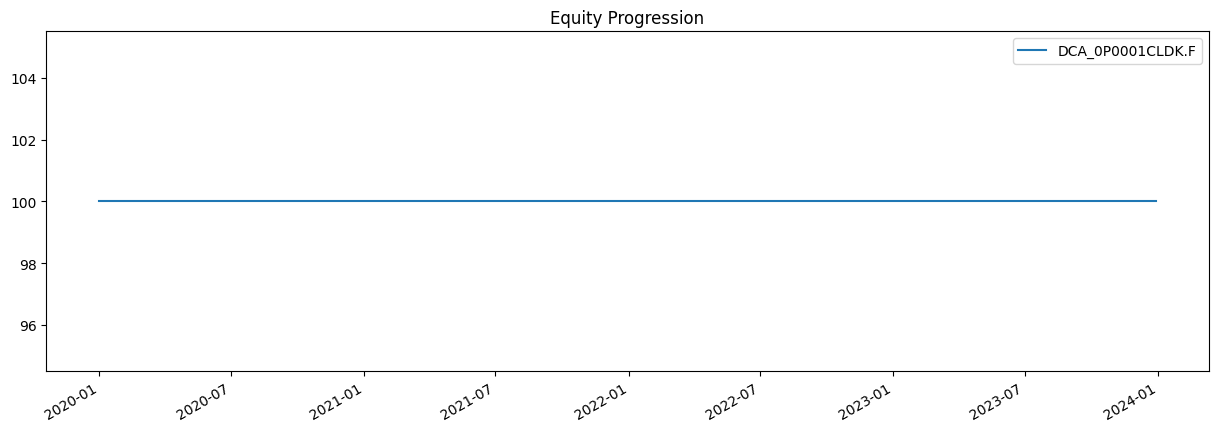

In [16]:
import bt
import pandas as pd
import yfinance as yf
import logging

# Configuración básica de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DCAStrategy(bt.Strategy):
    """
    Estrategia Dollar Cost Averaging (DCA)
    Invierte una cantidad fija en intervalos regulares.
    """
    
    def __init__(self, name, data, investment_amount=150, frequency='2W'):
        """
        Args:
            name (str): Nombre de la estrategia
            data (pd.Series): Serie temporal de precios
            investment_amount (float): Cantidad fija a invertir en cada intervalo
            frequency (str): Frecuencia de inversión ('D' para diario, 'W' para semanal, '2W' para cada dos semanas)
        """
        super().__init__(name)
        self.data = data
        self.investment_amount = investment_amount
        self.frequency = frequency
    
    def __call__(self, target):
        # Resampling de los datos según la frecuencia
        dates = self.data.resample(self.frequency).last().index
        
        # Crear serie de pesos
        weights = pd.Series(0, index=self.data.index)
        weights[weights.index.isin(dates)] = self.investment_amount / target.capital
        
        # Asignar pesos y rebalancear en fechas específicas
        target.weights = weights
        target.rebalance()

def run_backtest(ticker: str, start_date: str, end_date: str, frequency: str = '2W', 
                 investment_amount: float = 150) -> bt.backtest.Result:
    """
    Ejecuta el backtest de la estrategia DCA con inversión periódica.
    
    Args:
        ticker (str): Símbolo del activo
        start_date (str): Fecha de inicio (YYYY-MM-DD)
        end_date (str): Fecha final (YYYY-MM-DD)
        frequency (str): Frecuencia de inversión
        investment_amount (float): Cantidad a invertir en cada intervalo
        
    Returns:
        bt.backtest.Result: Resultados del backtest
    """
    # Obtener datos
    logger.info(f"Descargando datos para {ticker}")
    df = yf.download(ticker, start=start_date, end=end_date)
    data = df['Adj Close']
    
    # Ya tenemos un DataFrame con índice, sólo renombramos la columna
    price_df = pd.DataFrame(data)
    price_df.columns = [ticker]
    
    # Crear estrategia y backtest con capital inicial cero
    strategy_name = f"DCA_{ticker}"
    strategy = DCAStrategy(strategy_name, data, investment_amount=investment_amount, frequency=frequency)
    backtest = bt.Backtest(
        strategy,
        price_df,
        initial_capital=0,  # Empezamos con un capital inicial de 0
        commissions=lambda q, p: abs(q) * p * 0.001  # 0.1% de comisión
    )
    
    # Ejecutar backtest
    return bt.run(backtest)

def main():
    # Parámetros
    ticker = '0P0001CLDK.F'
    start_date = '2020-01-01'
    end_date = '2023-12-31'
    investment_amount = 150  # Cantidad a invertir cada dos semanas
    frequency = '2W'  # Inversión cada dos semanas
    
    # Ejecutar backtest
    results = run_backtest(
        ticker=ticker,
        start_date=start_date,
        end_date=end_date,
        frequency=frequency,
        investment_amount=investment_amount
    )
    
    # Mostrar resultados
    print("\nResumen de la estrategia DCA:")
    print(results.display())
    print("\nEstadísticas detalladas:")
    print(results.stats)
    
    # Visualizar resultados
    results.plot()
    
    return results

if __name__ == "__main__":
    results = main()




